In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
!pip install -q scikit-learn seaborn joblib


In [4]:
# Step 1: find any zip files in /content and unzip the first one found
import glob, os, sys, subprocess

zip_files = glob.glob('/content/*.zip')
print("Found zip files:", zip_files)
if not zip_files:
    raise FileNotFoundError("No .zip files found in /content. Upload the zip and re-run this cell.")
zip_path = zip_files[0]
print("Using zip:", zip_path)

# unzip to /content/data
!mkdir -p /content/data
!unzip -o "/content/archive (2).zip" -d /content/data

print("Files in /content/data:")
!ls -la /content/data


Found zip files: ['/content/archive (2).zip']
Using zip: /content/archive (2).zip
Archive:  /content/archive (2).zip
  inflating: /content/data/IRIS.csv  
Files in /content/data:
total 16
drwxr-xr-x 2 root root 4096 Dec  7 08:34 .
drwxr-xr-x 1 root root 4096 Dec  7 08:34 ..
-rw-r--r-- 1 root root 4617 Apr 22  2025 IRIS.csv


In [5]:
import glob
csvs = glob.glob('/content/data/*.csv')
print("CSV files found:", csvs)
if not csvs:
    # sometimes csv is at top-level
    csvs = glob.glob('/content/*.csv')
    print("Also searched /content, found:", csvs)
if not csvs:
    raise FileNotFoundError("No CSV found in /content/data or /content. Check the unzipped content.")
csv_path = csvs[0]  # use first CSV found
print("Will load:", csv_path)


CSV files found: ['/content/data/IRIS.csv']
Will load: /content/data/IRIS.csv


In [6]:
import pandas as pd
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Shape: (150, 5)
Columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
# Robust renaming for common Kaggle iris variants
rename_map = {
    'SepalLengthCm':'sepal_length',
    'Sepal Width':'sepal_width',
    'Sepal width':'sepal_width',
    'Sepal length':'sepal_length',
    'SepalLength':'sepal_length',
    'Sepal_Length':'sepal_length',
    'Sepal Width (cm)':'sepal_width',
    'Sepal length (cm)':'sepal_length',
    'Sepal width (cm)':'sepal_width',
    'SepalLengthCm':'sepal_length',
    'SepalWidthCm':'sepal_width',
    'PetalLengthCm':'petal_length',
    'PetalWidthCm':'petal_width',
    'Petal length (cm)':'petal_length',
    'Petal width (cm)':'petal_width',
    'PetalLength':'petal_length',
    'Petal_Length':'petal_length',
    'PetalWidthCm':'petal_width',
    'Species':'species',
    'species ':'species',   # trailing space
    'class':'species',
    'variety':'species',
    'type':'species'
}

# apply renaming where applicable
available_renames = {k:v for k,v in rename_map.items() if k in df.columns}
if available_renames:
    df = df.rename(columns=available_renames)
    print("Applied renames:", available_renames)
else:
    print("No common renames applied; existing columns:", df.columns.tolist())

# drop Id or index-like columns if present
for drop_col in ['Id','id','ID','index']:
    if drop_col in df.columns:
        df = df.drop(columns=[drop_col])
        print("Dropped column:", drop_col)

# Ensure required final columns exist
expected = ['sepal_length','sepal_width','petal_length','petal_width','species']
missing = [c for c in expected if c not in df.columns]
if missing:
    print("Missing columns after rename:", missing)
    print("Current columns:", df.columns.tolist())
    raise Exception("Cannot continue until you rename or create the expected columns. Edit df.columns or tell me the actual names.")
else:
    df = df[expected]
    print("Final dataframe ready with columns:", df.columns.tolist())
    display(df.head())


No common renames applied; existing columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
Final dataframe ready with columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Shape: (150, 5)
Class counts:
 species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


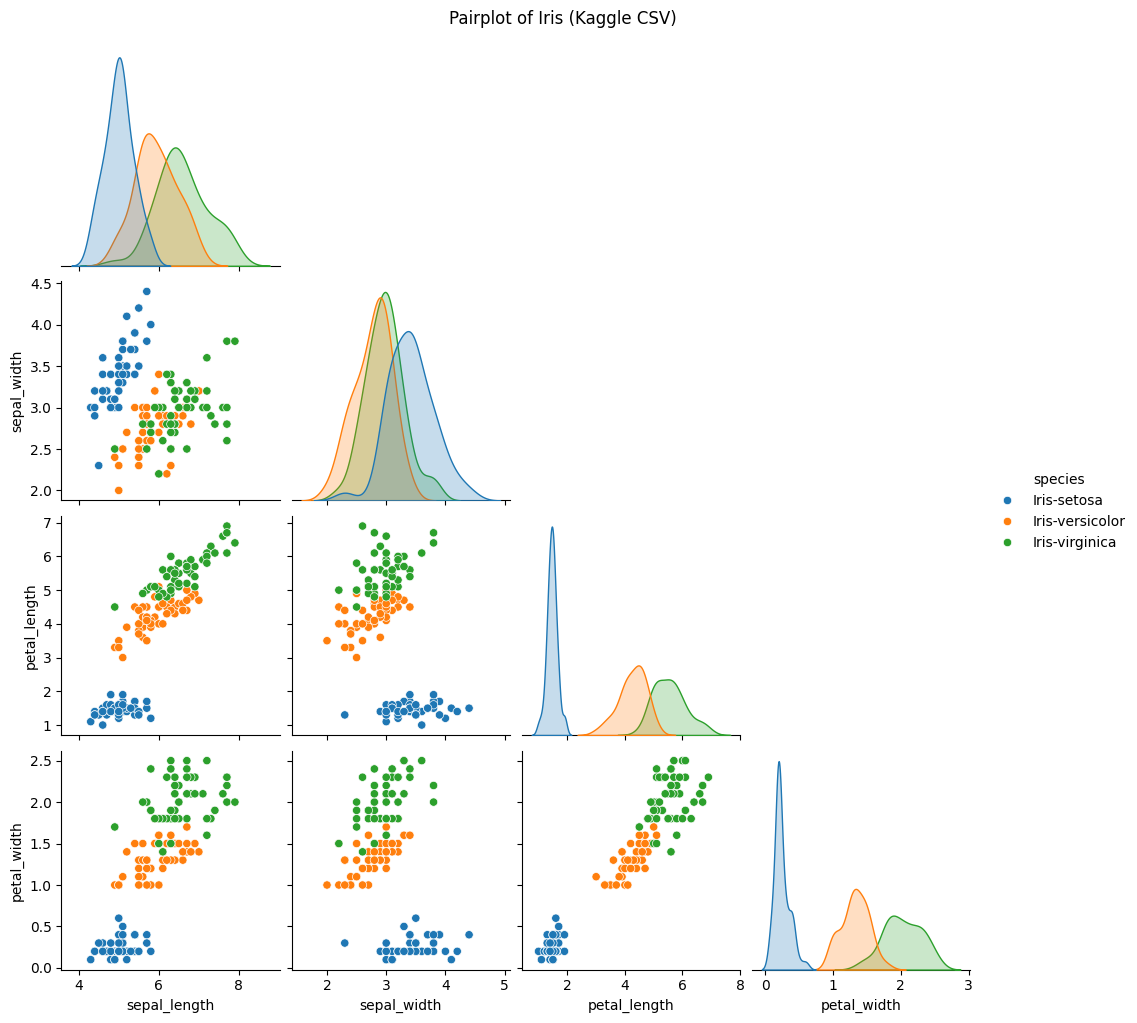

In [8]:
print("Shape:", df.shape)
print("Class counts:\n", df['species'].value_counts())
display(df.describe())

# Pairplot (fast)
import seaborn as sns, matplotlib.pyplot as plt
sns.pairplot(df, hue='species', corner=True)
plt.suptitle("Pairplot of Iris (Kaggle CSV)", y=1.02)
plt.show()


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

features = ['sepal_length','sepal_width','petal_length','petal_width']
X = df[features].values
y = LabelEncoder().fit_transform(df['species'].values)  # maps species -> 0/1/2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (120, 4) Test shape: (30, 4)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pip_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
pip_log = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression(max_iter=2000))])
pip_dt  = Pipeline([('dt', DecisionTreeClassifier(random_state=42))])

grid_knn = {'knn__n_neighbors': [3,5,7]}
grid_log = {'log__C': [0.1,1,10]}
grid_dt  = {'dt__max_depth': [None,2,3]}

gs_knn = GridSearchCV(pip_knn, grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
gs_log = GridSearchCV(pip_log, grid_log, cv=5, scoring='accuracy', n_jobs=-1)
gs_dt  = GridSearchCV(pip_dt, grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

print("Fitting k-NN...")
gs_knn.fit(X_train, y_train)
print("Fitting Logistic Regression...")
gs_log.fit(X_train, y_train)
print("Fitting Decision Tree...")
gs_dt.fit(X_train, y_train)

print("kNN best:", gs_knn.best_params_, "cv acc:", gs_knn.best_score_)
print("Logistic best:", gs_log.best_params_, "cv acc:", gs_log.best_score_)
print("DecisionTree best:", gs_dt.best_params_, "cv acc:", gs_dt.best_score_)


Fitting k-NN...
Fitting Logistic Regression...
Fitting Decision Tree...
kNN best: {'knn__n_neighbors': 5} cv acc: 0.9666666666666668
Logistic best: {'log__C': 10} cv acc: 0.9666666666666668
DecisionTree best: {'dt__max_depth': None} cv acc: 0.9416666666666668



kNN Test accuracy: 0.9333
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



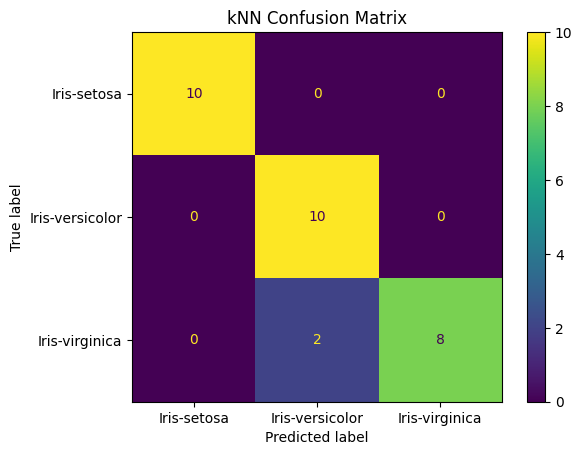


Logistic Test accuracy: 1.0000
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



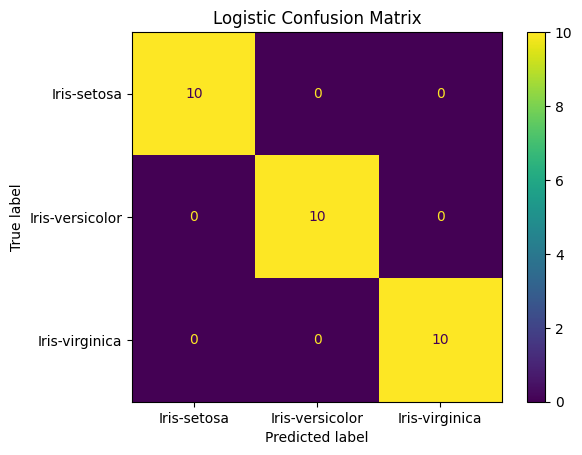


DecisionTree Test accuracy: 0.9333
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



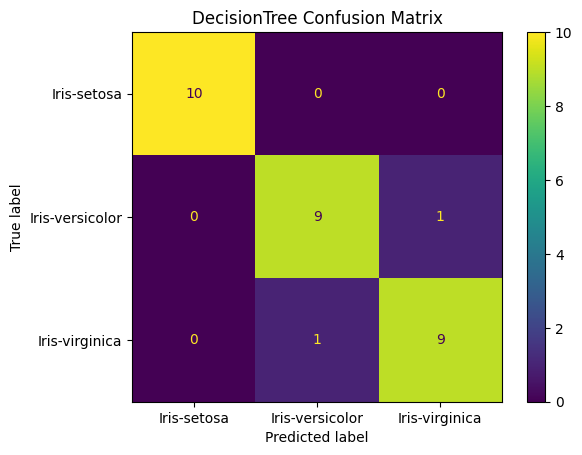

Best model on test set: Logistic with accuracy: 1.0


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

models = {
    'kNN': gs_knn.best_estimator_,
    'Logistic': gs_log.best_estimator_,
    'DecisionTree': gs_dt.best_estimator_
}

best_acc = -1
best_model = None
best_name = None

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Test accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=pd.unique(df['species'])))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=pd.unique(df['species']))
    disp.plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_name = name

print("Best model on test set:", best_name, "with accuracy:", best_acc)


In [12]:
import joblib
save_dir = '/content/drive/MyDrive/iris_project'
!mkdir -p "{save_dir}"

save_path = f"{save_dir}/best_model.joblib"
joblib.dump({'model': best_model, 'target_names': list(pd.unique(df['species']))}, save_path)
print("Saved model to:", save_path)


Saved model to: /content/drive/MyDrive/iris_project/best_model.joblib


In [13]:
# Load saved model (example)
obj = joblib.load(save_path)
model = obj['model']     # pipeline including scaler
target_names = obj['target_names']

# Example sample: [sepal_length, sepal_width, petal_length, petal_width]
sample = [[5.1, 3.5, 1.4, 0.2]]
pred_idx = model.predict(sample)
print("Predicted species:", target_names[pred_idx[0]])


Predicted species: Iris-setosa


In [14]:
readme_text = f"""
Iris Classification - Colab run (Kaggle CSV uploaded & used)

Files:
- best_model.joblib  (saved pipeline + target_names) : {save_path}
- notebook (.ipynb) saved in your Colab/Drive

How to do inference:
1) joblib.load('{save_path}') -> gives dict with 'model' and 'target_names'
2) model.predict([[sepal_l, sepal_w, petal_l, petal_w]])

Notes:
- The pipeline includes StandardScaler, so pass raw measurements in cm.
- This dataset came from the uploaded Kaggle zip.
"""
with open(f"{save_dir}/README.txt", 'w') as f:
    f.write(readme_text)
print("Saved README to:", f"{save_dir}/README.txt")


Saved README to: /content/drive/MyDrive/iris_project/README.txt


In [15]:
!ls -la /content/drive/MyDrive/iris_project


total 3
-rw------- 1 root root 1622 Dec  7 08:39 best_model.joblib
-rw------- 1 root root  552 Dec  7 08:39 README.txt


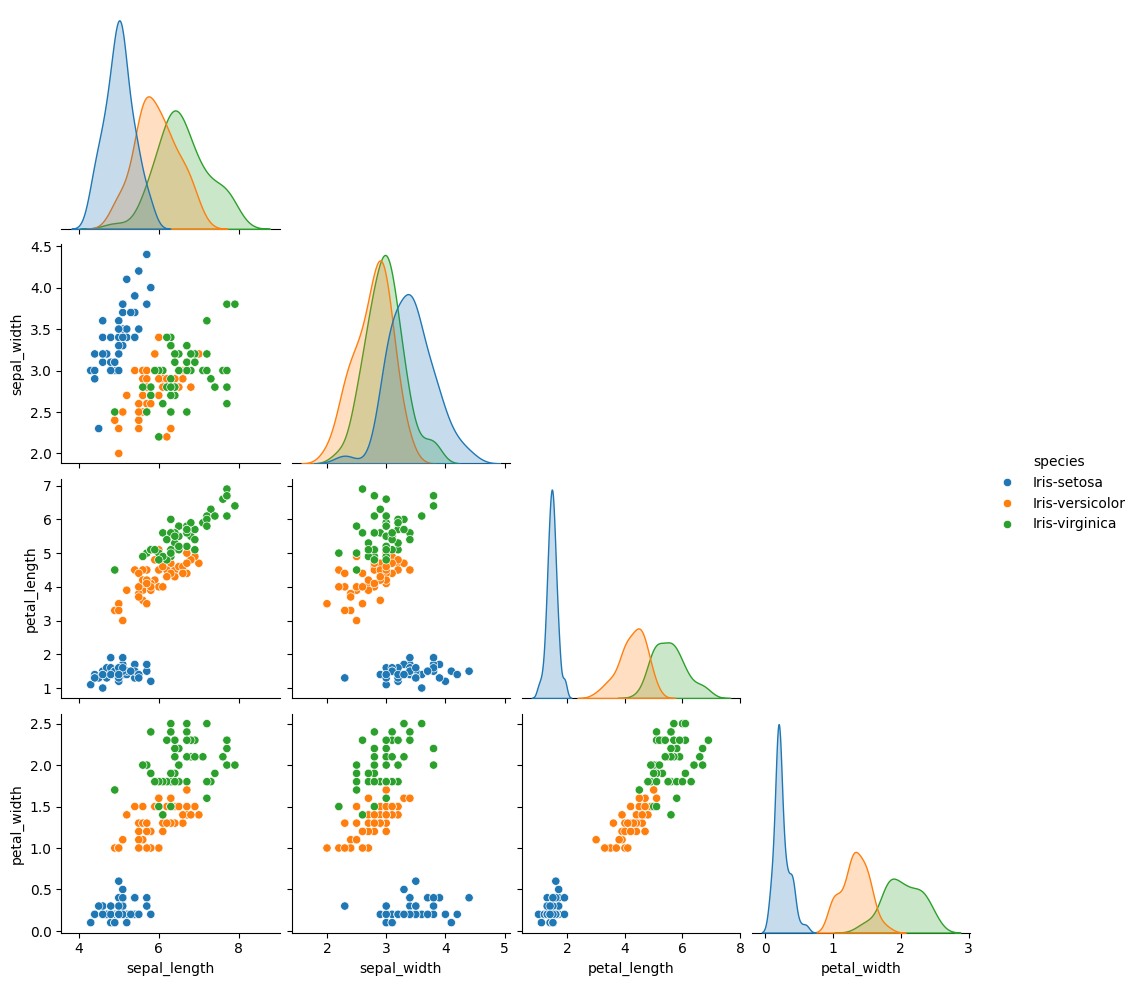

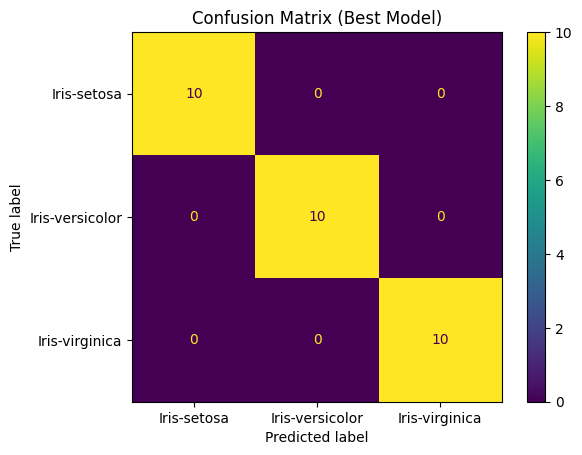

Plots saved successfully!


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib, pandas as pd
import os

save_dir = '/content/drive/MyDrive/iris_project'

# Load model
obj = joblib.load(os.path.join(save_dir, 'best_model.joblib'))
model = obj['model']
target_names = obj.get('target_names', ['class0','class1','class2'])

# Load your CSV (adjust filename if needed)
# Using the csv_path variable that was correctly identified in previous cells
df = pd.read_csv(csv_path)

# Rename columns if needed
df = df.rename(columns={
    'SepalLengthCm':'sepal_length',
    'SepalWidthCm':'sepal_width',
    'PetalLengthCm':'petal_length',
    'PetalWidthCm':'petal_width',
    'Species':'species'
})

# ---- 1. Save Pairplot ----
sns.pairplot(df, hue='species', corner=True)
plt.savefig(os.path.join(save_dir, 'pairplot.png'), dpi=200, bbox_inches='tight')
plt.show()

# ---- 2. Save Confusion Matrix ----
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
y = LabelEncoder().fit_transform(df['species'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot()
plt.title("Confusion Matrix (Best Model)")
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=200, bbox_inches='tight')
plt.show()

print("Plots saved successfully!")

In [18]:
!ls -la /content/drive/MyDrive/iris_project


total 435
-rw------- 1 root root   1622 Dec  7 08:39 best_model.joblib
-rw------- 1 root root  53984 Dec  7 08:47 confusion_matrix.png
-rw------- 1 root root 387584 Dec  7 08:47 pairplot.png
-rw------- 1 root root    552 Dec  7 08:39 README.txt
